# Toxic Comment Classification Challenge

### Overview
We are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:
- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

### File descriptions
- train.csv - the training set, contains comments with their binary labels
- test.csv - the test set, you must predict the toxicity probabilities for these comments. To deter hand labeling, the test set contains some comments which are not included in scoring.
- sample_submission.csv - a sample submission file in the correct format
- test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)

### Task
- create a binary classifier which predict if a comment is toxic or not toxic 
- create a multilabel classifier which predicts a probability of each type of toxicity for each comment.

In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from collections import Counter

In [2]:
pd.options.display.max_colwidth = 300
pd.options.display.max_columns = 100

### Import Dataset
We merge train and test in all-in one dataset. After that we remove all comments which value -1

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
test_lab = pd.read_csv("./data/test_labels.csv")

In [4]:
test = test.merge(test_lab, on="id")
df = pd.concat([train, test])
df.reset_index(drop=True, inplace = True)
df.shape

(312735, 8)

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312735 entries, 0 to 312734
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             312735 non-null  object
 1   comment_text   312735 non-null  object
 2   toxic          312735 non-null  int64 
 3   severe_toxic   312735 non-null  int64 
 4   obscene        312735 non-null  int64 
 5   threat         312735 non-null  int64 
 6   insult         312735 non-null  int64 
 7   identity_hate  312735 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 19.1+ MB


In [7]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000,312735.000000
mean,-0.216803,-0.278907,-0.246362,-0.282978,-0.249035,-0.278411
std,0.553674,0.462240,0.513134,0.455311,0.509224,0.463074
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [9]:
# Delete all comments not used for scoring (value equals to -1)
df = df[df['toxic']!= -1]
df.shape

(223549, 8)

#### Make TOXIC feature:
- =0 if the comment is not marked as toxic (no labelled)
- =1 if exist at least a toxic label setted as 1

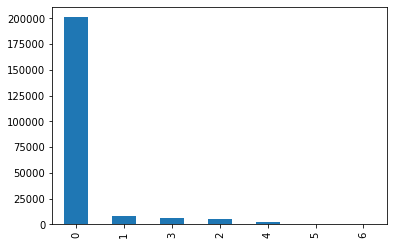

In [10]:
rowSums = df.iloc[:,2:].sum(axis=1)
rowSums.value_counts().plot(kind='bar')
plt.show()

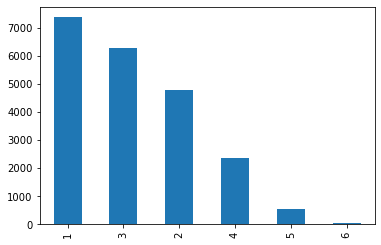

In [11]:
rowSums = df[df['toxic']==1].iloc[:,2:].sum(axis=1)
rowSums.value_counts().plot(kind='bar')
plt.show()

In [12]:
rowSums.value_counts(normalize=True)

1    0.344931
3    0.293163
2    0.223204
4    0.110877
5    0.025720
6    0.002104
dtype: float64

In [13]:
df['TOXIC'] = (df.iloc[:, 2:].sum(axis=1) > 0).astype(int)
df['TOXIC'].value_counts()

0    201081
1     22468
Name: TOXIC, dtype: int64

In [14]:
num_toxic_comments = df['TOXIC'].value_counts()[0]
ratio_num_toxic = "{:.2f}".format(num_toxic_comments*100/len(df))

num_notoxic_comments = len(df) - num_toxic_comments
ratio_num_no_toxic = "{:.2f}".format(num_notoxic_comments*100/len(df))

print(f"No Toxic Comments: {ratio_num_toxic} ({num_toxic_comments})" )
print(f"Toxic Comments: {ratio_num_no_toxic} ({num_notoxic_comments})" )

No Toxic Comments: 89.95 (201081)
Toxic Comments: 10.05 (22468)


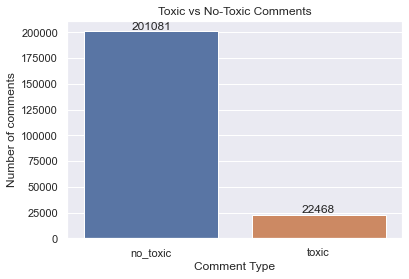

In [15]:
categories = ['no_toxic','toxic']
sns.set(font_scale = 1)

ax= sns.barplot(categories, [num_toxic_comments,num_notoxic_comments])
plt.title("Toxic vs No-Toxic Comments")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type')

#adding the text labels
rects = ax.patches
labels = [num_toxic_comments,num_notoxic_comments]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

In [16]:
categories = list(df.columns[2:-1])
categories

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

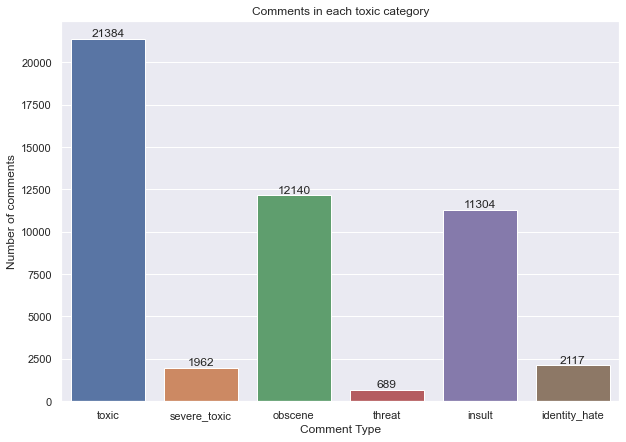

In [17]:
# Each toxic comment can be tagged with 1+ toxic categories. So the sum of all 
# comments is more greater than the total.

sns.set(font_scale = 1)
plt.figure(figsize=(10,7))

ax= sns.barplot(categories, df.iloc[:,2:-1].sum().values)
plt.title("Comments in each toxic category")
plt.ylabel('Number of comments')
plt.xlabel('Comment Type')

#adding the text labels
rects = ax.patches
labels = df.iloc[:,2:-1].sum().values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
    
plt.show()

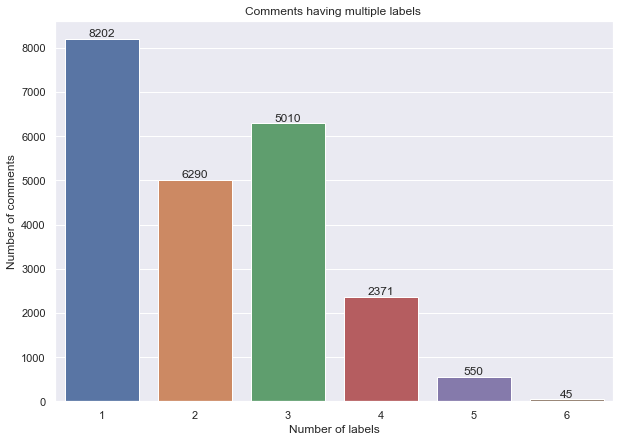

In [18]:
rowSums = df.iloc[:,2:-1].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts  = multiLabel_counts.iloc[1:]

plt.figure(figsize=(10,7))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments')
plt.xlabel('Number of labels')

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [19]:
#Adding some features
df['char_counts'] = df['comment_text'].apply(lambda x: len(x))
df['word_counts'] = df['comment_text'].apply(lambda x: len(x.split()))
df['unique_word_counts'] = df['comment_text'].apply(lambda x: len(set(x.split())))

In [20]:
df[['char_counts','word_counts','unique_word_counts']].describe()

,char_counts,word_counts,unique_word_counts
count,223549.000000,223549.000000,223549.000000
mean,391.012709,66.517166,47.475278
std,592.862955,99.474533,54.367195
min,1.000000,1.000000,1.000000
25%,93.000000,16.000000,15.000000
50%,203.000000,35.000000,31.000000
75%,431.000000,74.000000,58.000000
max,5000.000000,2321.000000,821.000000


(0.0, 2000.0)

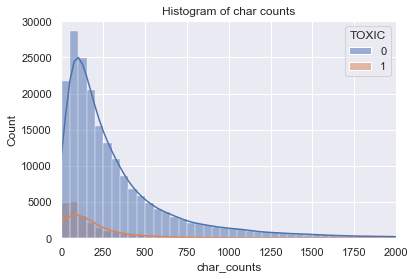

In [21]:
ax = sns.histplot(data=df, x="char_counts",bins=100, hue="TOXIC",kde=True)
plt.title("Histogram of char counts")
ax.set_xlim(0,2000)

(0.0, 500.0)

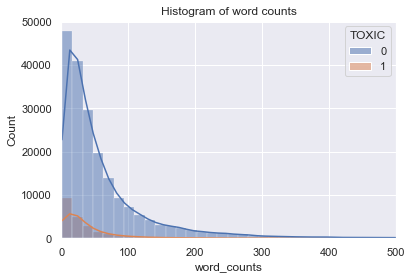

In [22]:
ax = sns.histplot(data=df, x="word_counts",bins=150, hue="TOXIC",kde=True)
plt.title("Histogram of word counts")
ax.set_xlim(0,500)

(0.0, 300.0)

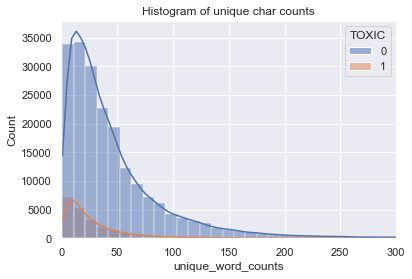

In [23]:
ax = sns.histplot(data=df, x="unique_word_counts",bins=80, hue="TOXIC",kde=True)
plt.title("Histogram of unique char counts")
ax.set_xlim(0,300)

In [24]:
df.nlargest(1, columns='char_counts').iloc[:,1]

4174    ii CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORNIA, CHULA VISTA, FUCKING GET YOUR INFORMATION RIGHT FAGGOT SHITHEAD!!i CAN STILL POST WITH THIS COMPUTER...I SAID BLOCK ME, COME THE FUCK DOWN HERE AND ARREST ME...SAN DIEGO CALIFORN...
Name: comment_text, dtype: object

In [25]:
df.nlargest(1, columns='word_counts').iloc[:,1]

259063    C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I E - F U C K E R C O M M I ...
Name: comment_text, dtype: object

In [26]:
#Hashtag in text
hashtags = df['comment_text'].apply(lambda x: re.findall(r"#\w*", x))
merged = list(itertools.chain.from_iterable(hashtags.to_list()))
len(merged)

11559

In [27]:
# @... in text
at = df['comment_text'].apply(lambda x: re.findall(r"@\w*", x))
merged = list(itertools.chain.from_iterable(at.to_list()))
len(merged)

2233

In [28]:
#emojii in text
import emoji

EMOJI_PATTERN = emoji.get_emoji_regexp()
emoji_ = df["comment_text"].apply(lambda x: EMOJI_PATTERN.findall(x))
merged = list(itertools.chain.from_iterable(emoji_.to_list()))
len(merged)

2894

In [31]:
x = Counter(merged)
x.most_common(10)

[('♥', 915),
 ('♦', 270),
 ('✉', 174),
 ('☎', 169),
 ('♣', 152),
 ('™', 145),
 ('©', 143),
 ('☺', 138),
 ('♠', 123),
 ('®', 88)]

## Text Cleaning

In [34]:
import contractions
#from autocorrect import Speller
import nltk
#spell = Speller()

In [35]:
def clean_text(text):
    text = text.encode("ascii", errors="ignore").decode() #Remove non ASCII
    text = text.lower()
    text = re.sub(r"(\n|\r|\t)+", " ", text) #remove \n, \r, \t
    text = contractions.fix(text) #Remove contractions (i'm --> i am)
    #text = spell(text) # Spelling is slow
    text = re.sub(r"\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}", "", text) #Remove IP Address
    text = re.sub(r"https?://\S+|www\.\S+", "", text) #Remove URLs
    text = re.sub(r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))", "", text) #Remove Email
    text = re.sub(r"\[\[User.*", "", text) #Remove username
    text = re.sub(r'[]!"$%&\'()*+,./:;=#@?[\\^_`{|}~-]+', "", text) #Remove punctuation (si vuole fare?)
 #   text = re.sub(r"(\w+.jpg$|\w+.png$)", "") #Remove filename (.jpg, .png, etc...)
    text = text.rstrip() #remove additional white space
    
    return text

In [36]:
import tqdm

clean_texts=[]
for text in tqdm.tqdm(df.comment_text):
    clean_texts.append(clean_text(text))

df['clean_text'] = clean_texts

100%|██████████| 223549/223549 [00:32<00:00, 6885.90it/s]


In [37]:
df['comment_text'][0], df['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

## Text Preprocessing

In [38]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

#PoS Tagging
nltk.download('averaged_perceptron_tagger')

stemmer = PorterStemmer()
lmtzr = WordNetLemmatizer()

stopwords = stopwords.words('english')
", ".join(stopwords)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/francesco.gemignani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/francesco.gemignani/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/francesco.gemignani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/francesco.gemignani/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/francesco.gemignani/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [39]:
#Tokenize
df['tokenized'] = df['clean_text'].apply(word_tokenize)

In [40]:
#Tokenize no stopwords
df['tokenized_no_stopwords'] = df['tokenized'].apply(lambda words: [word for word in words if word not in stopwords])

In [41]:
import sys
print(sys.getrecursionlimit())
sys.setrecursionlimit(5000)

3000


In [42]:
#Stemming
stem_list = []
for row in tqdm.tqdm(df['tokenized_no_stopwords']):
    stem_list.append([ stemmer.stem(word) for word in row ])

df['tokenized_stemmed'] = stem_list
#df['tokenized_stemmed'] = df['tokenized_no_stopwords'].apply(lambda words: [stemmer.stem(word) for word in words])

100%|██████████| 223549/223549 [02:48<00:00, 1325.38it/s]


In [43]:
#PoS
pos_list = []
for row in tqdm.tqdm(df['tokenized_no_stopwords']):
    pos_list.append(nltk.pos_tag(row))

df['tokenized_pos'] = pos_list
#df['tokenized_pos'] = df['tokenized_no_stopwords'].apply(lambda words: nltk.pos_tag(words))

100%|██████████| 223549/223549 [07:40<00:00, 485.16it/s]


In [44]:
#Lemma without PoS
df['tokenized_lemmatized'] = df['tokenized_no_stopwords'].apply(lambda words: [lmtzr.lemmatize(word) for word in words])

In [45]:
#Lemma with PoS
lemma_list = []

for words in tqdm.tqdm(df['tokenized_pos']):
    tmp=[]
    for lemma, pos in words:
        if pos.startswith("NN"):
            tmp.append(lmtzr.lemmatize(lemma, pos='n'))
        elif pos.startswith('VB'):
            tmp.append(lmtzr.lemmatize(lemma, pos='v'))
        elif pos.startswith('JJ'):
            tmp.append(lmtzr.lemmatize(lemma, pos='a'))
        elif pos.startswith('R'):
            tmp.append(lmtzr.lemmatize(lemma, pos='r'))
        else:
            tmp.append(lmtzr.lemmatize(lemma))
            
    lemma_list.append(tmp)
    
df['tokenized_lemmatized_pos'] = lemma_list

100%|██████████| 223549/223549 [00:33<00:00, 6607.33it/s]


In [46]:
#Bigrams
df['tokenized_bigram'] = df['tokenized_no_stopwords'].apply(lambda words: list(nltk.ngrams(words, 2)))

In [50]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,TOXIC,char_counts,word_counts,unique_word_counts,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0,0,264,43,41,explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now,"[explanation, why, the, edits, made, under, my, username, hardcore, metallica, fan, were, reverted, they, were, not, vandalisms, just, closure, on, some, gas, after, i, voted, at, new, york, dolls, fac, and, please, do, not, remove, the, template, from, the, talk, page, since, i, am, retired, now]","[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]","[explan, edit, made, usernam, hardcor, metallica, fan, revert, vandal, closur, ga, vote, new, york, doll, fac, pleas, remov, templat, talk, page, sinc, retir]","[(explanation, NN), (edits, NNS), (made, VBN), (username, JJ), (hardcore, NN), (metallica, NN), (fan, NN), (reverted, VBD), (vandalisms, JJ), (closure, NN), (gas, NN), (voted, VBD), (new, JJ), (york, NN), (dolls, NNS), (fac, JJ), (please, NN), (remove, VB), (template, NN), (talk, NN), (page, NN)...","[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalism, closure, gas, voted, new, york, doll, fac, please, remove, template, talk, page, since, retired]","[explanation, edits, make, username, hardcore, metallica, fan, revert, vandalisms, closure, gas, vote, new, york, doll, fac, please, remove, template, talk, page, since, retire]","[(explanation, edits), (edits, made), (made, username), (username, hardcore), (hardcore, metallica), (metallica, fan), (fan, reverted), (reverted, vandalisms), (vandalisms, closure), (closure, gas), (gas, voted), (voted, new), (new, york), (york, dolls), (dolls, fac), (fac, please), (please, rem..."
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0,0,112,17,17,daww he matches this background colour i am seemingly stuck with thanks talk 2151 january 11 2016 utc,"[daww, he, matches, this, background, colour, i, am, seemingly, stuck, with, thanks, talk, 2151, january, 11, 2016, utc]","[daww, matches, background, colour, seemingly, stuck, thanks, talk, 2151, january, 11, 2016, utc]","[daww, match, background, colour, seemingli, stuck, thank, talk, 2151, januari, 11, 2016, utc]","[(daww, NN), (matches, NNS), (background, IN), (colour, NN), (seemingly, RB), (stuck, JJ), (thanks, NNS), (talk, NN), (2151, CD), (january, NN), (11, CD), (2016, CD), (utc, NN)]","[daww, match, background, colour, seemingly, stuck, thanks, talk, 2151, january, 11, 2016, utc]","[daww, match, background, colour, seemingly, stuck, thanks, talk, 2151, january, 11, 2016, utc]","[(daww, matches), (matches, background), (background, colour), (colour, seemingly), (seemingly, stuck), (stuck, thanks), (thanks, talk), (talk, 2151), (2151, january), (january, 11), (11, 2016), (2016, utc)]"
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0,0,233,42,39,hey man i am really not trying to edit war it is just that this guy is constantly removing relevant information and tal

In [44]:
df.to_csv('data/final.zip')

### Word Cloud

In [51]:
from wordcloud import WordCloud
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

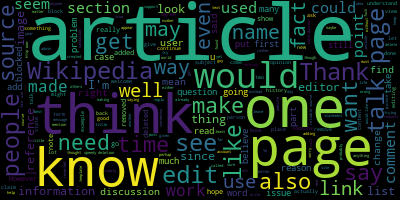

In [52]:
all_text = '\n'.join(df.comment_text)

wc = WordCloud(stopwords=stopwords)
wc.generate(all_text)
wc.to_image()

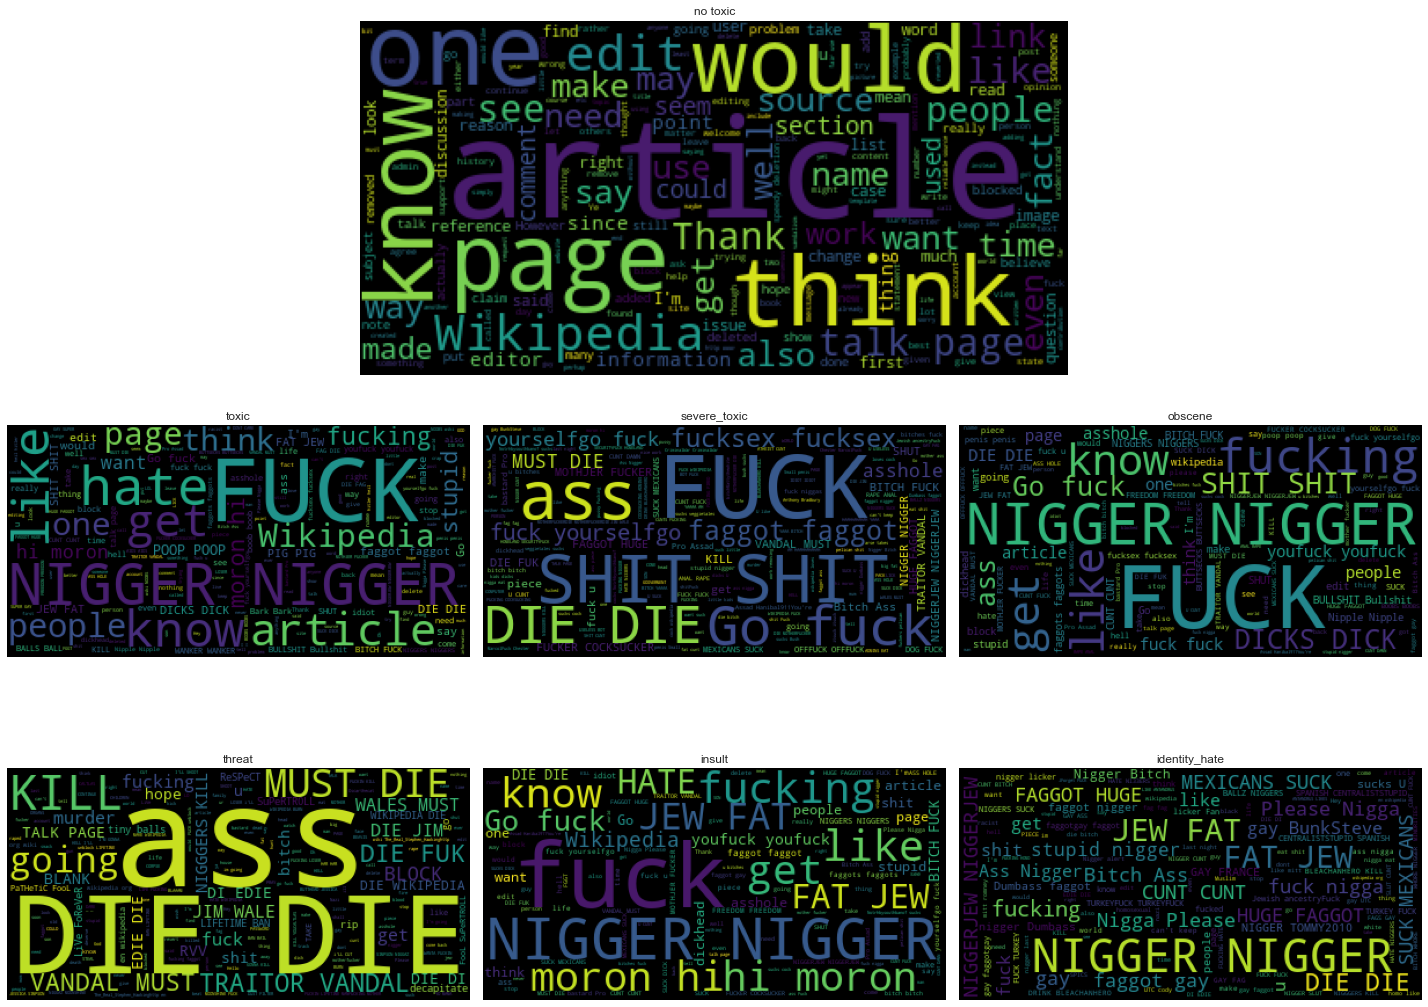

In [53]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))

plt.subplot2grid((3, 3), (0, 0), colspan=3)
all_text = '\n'.join(df.comment_text)
wc = WordCloud(stopwords=stopwords)
plt.imshow(wc.generate(all_text))
plt.axis("off")
plt.title("no toxic")

plt.subplot(3,3,4)
all_text = '\n'.join(df[df.toxic == 1].comment_text)
wc = WordCloud(stopwords=stopwords)
plt.imshow(wc.generate(all_text))
plt.axis("off")
plt.title("toxic")

plt.subplot(3,3,5)
all_text = '\n'.join(df[df.severe_toxic == 1].comment_text)
wc = WordCloud(stopwords=stopwords)
plt.imshow(wc.generate(all_text))
plt.axis("off")
plt.title("severe_toxic")

plt.subplot(3,3,6)
all_text = '\n'.join(df[df.obscene == 1].comment_text)
wc = WordCloud(stopwords=stopwords)
plt.imshow(wc.generate(all_text))
plt.axis("off")
plt.title("obscene")

plt.subplot(3,3,7)
all_text = '\n'.join(df[df.threat == 1].comment_text)
wc = WordCloud(stopwords=stopwords)
plt.imshow(wc.generate(all_text))
plt.axis("off")
plt.title("threat")

plt.subplot(3,3,8)
all_text = '\n'.join(df[df.insult == 1].comment_text)
wc = WordCloud(stopwords=stopwords)
plt.imshow(wc.generate(all_text))
plt.axis("off")
plt.title("insult")

plt.subplot(3,3,9)
all_text = '\n'.join(df[df.identity_hate == 1].comment_text)
wc = WordCloud(stopwords=stopwords)
plt.imshow(wc.generate(all_text))
plt.axis("off")
plt.title("identity_hate")

fig.tight_layout()
plt.show()

### Word Frequency

In [54]:
def top_k_words(tokenized_comments,title,xLabel,yLabel,k=20):
    freq_dist = nltk.FreqDist()
    for comment in tokenized_comments:
        for token in comment:
            freq_dist[token] += 1

    most_common = freq_dist.most_common(20)
    sns.barplot([elem[0] for elem in most_common],[elem[1] for elem in most_common])
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.xticks(rotation=90)
    plt.show()
    

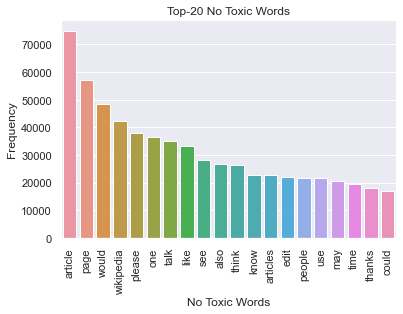

In [55]:
no_toxic = df[df['TOXIC']==0]['tokenized_no_stopwords'].to_list()
top_k_words(no_toxic,"Top-20 No Toxic Words","No Toxic Words","Frequency")

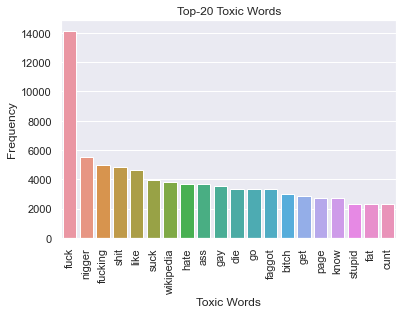

In [56]:
toxic = df[df.toxic == 1]['tokenized_no_stopwords'].to_list()
top_k_words(toxic,"Top-20 Toxic Words","Toxic Words","Frequency")

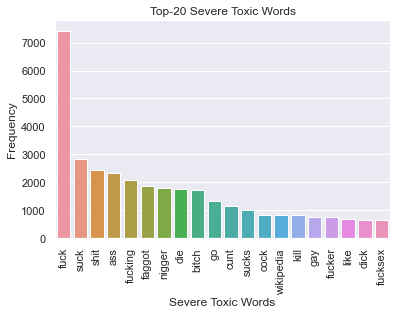

In [57]:
severe_toxic = df[df.severe_toxic == 1]['tokenized_no_stopwords'].to_list()
top_k_words(severe_toxic,"Top-20 Severe Toxic Words","Severe Toxic Words","Frequency")

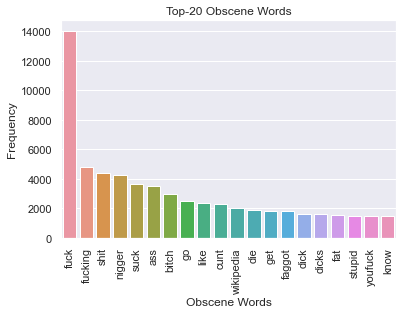

In [58]:
obscene = df[df.obscene == 1]['tokenized_no_stopwords'].to_list()
top_k_words(obscene,"Top-20 Obscene Words","Obscene Words","Frequency")

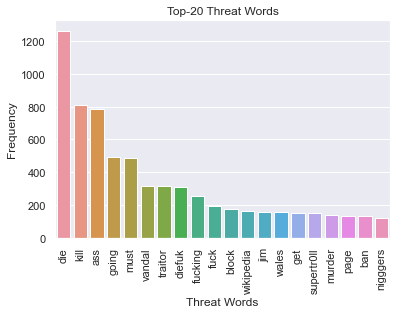

In [59]:
threat = df[df.threat == 1]['tokenized_no_stopwords'].to_list()
top_k_words(threat,"Top-20 Threat Words","Threat Words","Frequency")

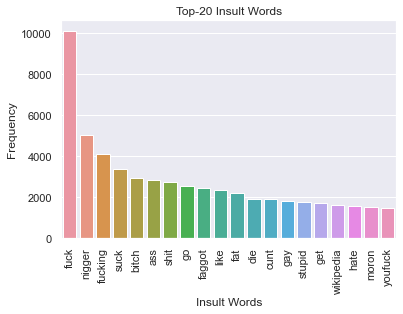

In [60]:
insult = df[df.insult == 1]['tokenized_no_stopwords'].to_list()
top_k_words(insult,"Top-20 Insult Words","Insult Words","Frequency")

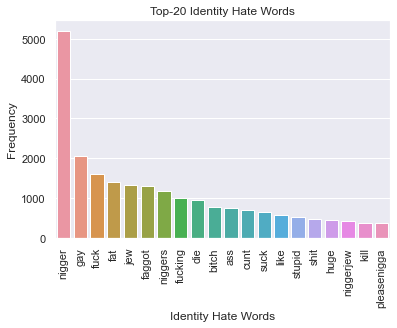

In [61]:
identity_hate = df[df.identity_hate == 1]['tokenized_no_stopwords'].to_list()
top_k_words(identity_hate,"Top-20 Identity Hate Words","Identity Hate Words","Frequency")

### Correlation between toxic label

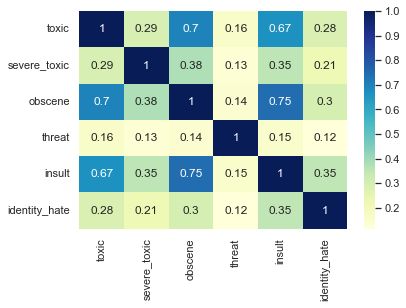

In [19]:
corrMatrix = df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].corr()
sns.heatmap(corrMatrix, cmap="YlGnBu",annot=True)
plt.show()

#### Alcune considerazioni:

Falleni
- Topic modeling???
- Dal momento che dobbiamo effettuare un confronto tra vari modelli, forse non conviene unire i dataset di train e di test per poi splittarli nuovamente in fase di fitting. Facciamo su entrambi gli stessi preprocessing e teniamoli da subito separati. (così abbiamo un dataset uguale per tutti con cui valutare le performance e trarre delle conclusioni)
- analizzare le relazioni tra le classi tossiche
- forse conviene concentrarci e fare bene il task multilabel da subito?? il task binario può essere una perdita di tempo?
- migliorare data understanding con gli score del tf-idf ?
- rimuovere dal testo emojii? html? altro???
- introdurre uno Speller per correggere errori di scrittura? (ci sono un pò di librerie, ne ho provata una ma come vedi l'ho dovuta togliere perchè troppo lenta)
- ho generato i bigrams, vogliamo provare anche i trigrams? ...
- creazione di nuove feature come "numero di parole uniche in una frase" o "lunghezze in caratteri della frase" ecc...???


Gemignani
- Renderlo eseguibile da colab!?!?. Scaricare da kaggle e unzippare i files in una folder https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/
- All-in dataset (nel test set ci sono label a -1)
https://www.kaggle.com/adldotori/all-in-one-dataset
- task_1: toxic or no-toxic (0,0,0,0,0,0)
- task_2: assegnare dei pesi alle label (non disgiunte - nn è un multiclass) in base alla gravità!